In [1]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from datasets import load_dataset
from utils import preprocess_function, filter_function
from transformers import AutoTokenizer
from lib.dbengine import DBEngine
from lib.query import Query
import re

In [2]:
path = '../datasets/wikisql/data'
dataset = load_dataset(path)
train_data = dataset["train"]
val_data = dataset["validation"]

In [3]:
tokenizer = AutoTokenizer.from_pretrained("google/t5-efficient-tiny")
tokenized_dataset = dataset.map(lambda batch: preprocess_function(batch, tokenizer, input_max_length=None, output_max_length=None, padding="do_not_pad"), batched=True, batch_size=2048, load_from_cache_file=False)

Map:   0%|          | 0/56355 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/8421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15878 [00:00<?, ? examples/s]

In [21]:
tokenized_train_data = tokenized_dataset["train"]
tokenized_val_data = tokenized_dataset["validation"]

In [19]:
def sequence_length_histograms(data):
    # Calculate sequence lengths for inputs and labels
    input_lengths = [len(seq) for seq in data["input_ids"]]
    label_lengths = [len(seq) for seq in data["labels"]]
    
    # Determine bins
    bins_inputs = max(input_lengths) - min(input_lengths) + 1
    bins_labels = max(label_lengths) - min(label_lengths) + 1
    
    # Create side-by-side histograms
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Plot histogram for input lengths
    axes[0].hist(input_lengths, bins=bins_inputs, alpha=0.7, color='blue', edgecolor='black')
    axes[0].axvline(np.mean(input_lengths), color='red', linestyle='dashed', linewidth=1, label='Mean Length')
    axes[0].set_xlabel('Input Sequence Length')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Histogram of Input Sequence Lengths')
    axes[0].legend()
    
    # Plot histogram for label lengths
    axes[1].hist(label_lengths, bins=bins_labels, alpha=0.7, color='green', edgecolor='black')
    axes[1].axvline(np.mean(label_lengths), color='red', linestyle='dashed', linewidth=1, label='Mean Length')
    axes[1].set_xlabel('Label Sequence Length')
    axes[1].set_title('Histogram of Label Sequence Lengths')
    axes[1].legend()
    
    # Show the plots
    plt.tight_layout()
    plt.show()

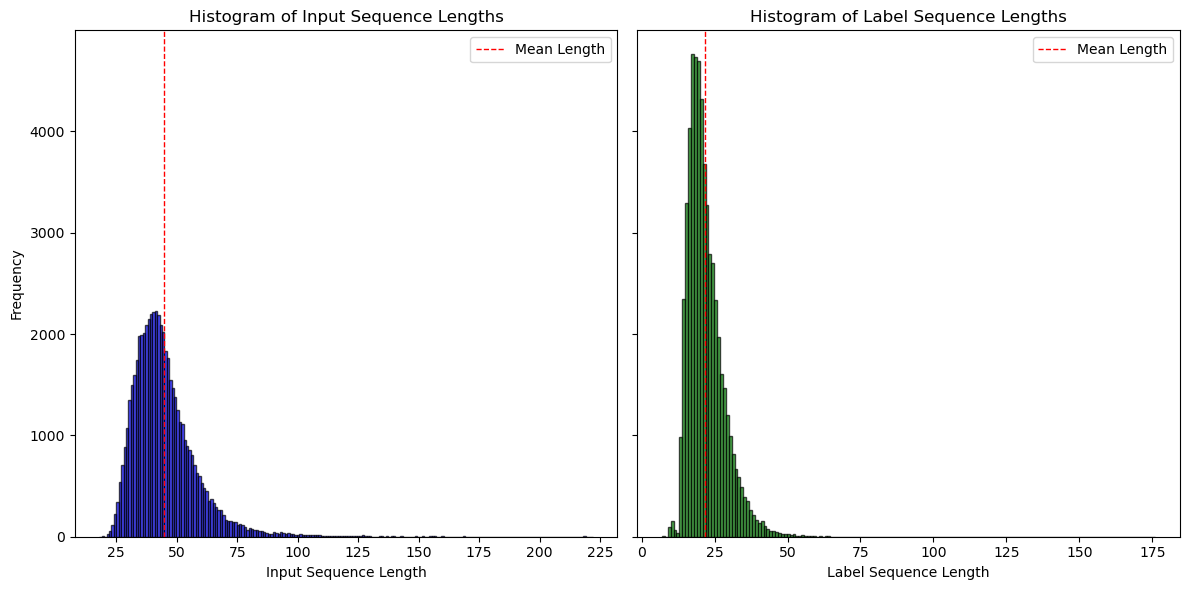

In [22]:
sequence_length_histograms(tokenized_train_data)

In [33]:
input_lengths = [len(seq) for seq in tokenized_train_data["input_ids"]]
sorted_input_indices = sorted(range(len(input_lengths)), key=lambda i: input_lengths[i])
label_lengths = [len(seq) for seq in tokenized_train_data["labels"]]
sorted_label_indices = sorted(range(len(label_lengths)), key=lambda i: label_lengths[i])

In [40]:
tokenized_train_data[sorted_label_indices[6]]

{'phase': 1,
 'question': 'Who was the top picki n the draft?',
 'table': {'header': ['Round',
   'Choice',
   'Overall',
   'Player name',
   'Position',
   'College'],
  'page_title': '',
  'page_id': '',
  'types': ['real', 'real', 'real', 'text', 'text', 'text'],
  'id': '1-10360656-1',
  'section_title': '',
  'caption': '',
  'rows': [['1', '1', '1', 'Tommy Mason', 'Running Back', 'Tulane'],
   ['2', '1', '15', 'Rip Hawkins', 'Linebacker', 'North Carolina'],
   ['3', '1', '29', 'Fran Tarkenton', 'Quarterback', 'Georgia'],
   ['4', '1', '43', 'Chuck Lamson', 'Safety', 'Wyoming'],
   ['5', '1', '57', 'Ed Sharockman', 'Cornerback', 'Pittsburgh'],
   ['6', '1', '71', 'Jerry Burch', 'End', 'Georgia Tech'],
   ['7', '1', '85', 'Allan Ferrie', 'End', 'Wagner'],
   ['8', '1', '99', 'Paul Lindquist', 'Defensive Tackle', 'New Hampshire'],
   ['9',
    '1',
    '113',
    'Dan Sheehan',
    'Offensive Tackle',
    'Tennessee-Chattanooga'],
   ['10', '1', '127', 'Doug Mayberry', 'Fullback', 

In [ ]:
filtered_train_data = tokenized_train_data.filter(lambda sample: filter_function(sample, tokenizer))
filtered_train_data

In [ ]:
sequence_length_histograms(filtered_train_data)

In [46]:
db_path = '../datasets/wikisql/tables/train/train.db'
db_engine = DBEngine(db_path)

def empty_response_filter(batch):
    keep = []
    for table, sql in zip(batch["table"], batch["sql"]):
        sql["conds"] = list(zip(sql["conds"]["column_index"], sql["conds"]["operator_index"], sql["conds"]["condition"]))
        query = Query.from_dict(sql)
        gold_result = db_engine.execute_query(table["id"], query)
        if gold_result == [None]:
            keep.append(1)
        else:
            keep.append(0)

    return keep

In [48]:
wrong_data = train_data.filter(empty_response_filter, batched=True)
wrong_data

Filter:   0%|          | 0/56355 [00:00<?, ? examples/s]

Dataset({
    features: ['phase', 'question', 'table', 'sql', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 4323
})

In [18]:
from copy import deepcopy

db_path = '../datasets/wikisql/tables/train/train.db'
db_engine = DBEngine(db_path)

def fix_commas(batch):
    replaced = 0
    total = 0
    for batch_idx, (sql, table) in enumerate(zip(batch["sql"], batch["table"])):
        sql_copy = deepcopy(sql)
        sql_copy["conds"] = list(zip(sql["conds"]["column_index"], sql["conds"]["operator_index"], sql["conds"]["condition"]))
        query = Query.from_dict(sql_copy)
        gold_result = db_engine.execute_query(table["id"], query)
        if gold_result == [None]:
            for cond_idx, (column_idx, condition) in enumerate(zip(sql["conds"]["column_index"], sql["conds"]["condition"])):
                total = total + 1
                if table["types"][column_idx] == 'text':
                    fixed_cond, count = re.subn(r'(?<!\s)(?:(?<!\d),|,(?!\d))', ' ,', condition)
                    batch["sql"][batch_idx]["conds"]["condition"][cond_idx] = fixed_cond
                    replaced = replaced + count
    print(f'Replaced {replaced} out of {total} conditions.')
    return batch

maybe_fixed_data = train_data.map(fix_commas, batched=True, batch_size=9000)

Map:   0%|          | 0/56355 [00:00<?, ? examples/s]

Replaced 2 out of 2 conditions.
Replaced 12 out of 306 conditions.
Replaced 33 out of 2541 conditions.
Replaced 28 out of 1826 conditions.
Replaced 20 out of 1755 conditions.
Replaced 31 out of 2161 conditions.
Replaced 9 out of 497 conditions.


In [50]:
def fix_commas(batch):
    replaced = 0
    total = 0
    for batch_idx, (sql, table) in enumerate(zip(batch["sql"], batch["table"])):
        for cond_idx, (column, condition) in enumerate(zip(sql["conds"]["column_index"], sql["conds"]["condition"])):
            total = total + 1
            if table["types"][column] == 'text':
                batch["sql"][batch_idx]["conds"]["condition"][cond_idx], count = re.subn(r'(?<!\s)(?:(?<!\d),|,(?!\d))', ' ,', condition)
                replaced = replaced + count
    print(f'Replaced {replaced} out of {total} conditions.')
    return batch

maybe_fixed_data = train_data.map(fix_commas, batched=True, batch_size=None)

Map:   0%|          | 0/56355 [00:00<?, ? examples/s]

Replaced 2793 out of 76729 conditions.


In [51]:
wrong_fixed_data = maybe_fixed_data.filter(empty_response_filter, batched=True)
wrong_fixed_data

Filter:   0%|          | 0/56355 [00:00<?, ? examples/s]

Dataset({
    features: ['phase', 'question', 'table', 'sql', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 4474
})

In [52]:
import pandas as pd

data = {
    "ID": [table["id"] for table in wrong_fixed_data["table"]],
    "Header": [table["header"] for table in wrong_fixed_data["table"]],
    "Question": wrong_fixed_data["question"],
    "SQL Statement": [sql["human_readable"] for sql in wrong_fixed_data["sql"]]
}

df = pd.DataFrame(data)
df.to_csv('wrong_fixed_data.csv', index=False)

In [9]:
# Flatten the dataset to count unique tokens
all_tokens = [token for seq in tokenized_train_data["input_ids"] for token in seq]
unique_tokens = set(all_tokens)
print(f"Number of unique tokens: {len(unique_tokens)}")

Number of unique tokens: 15259


Calculating token frequencies...
Plotting token frequency histogram...


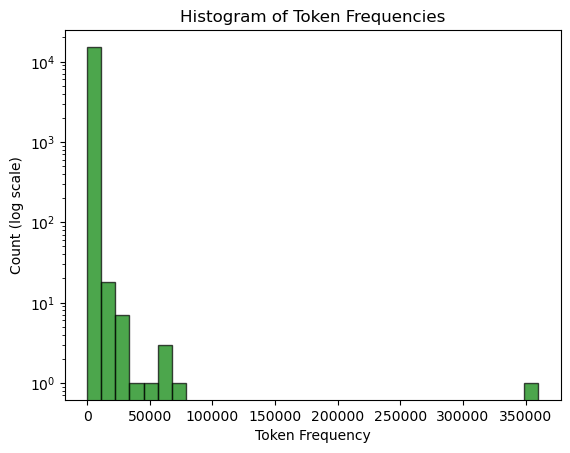

In [10]:
# Token frequency distribution
print("Calculating token frequencies...")
token_counts = Counter(all_tokens)

# Plot histogram of token counts
print("Plotting token frequency histogram...")
frequencies = list(token_counts.values())
plt.hist(frequencies, bins=32, alpha=0.7, color='green', edgecolor='black', log=True)
plt.xlabel('Token Frequency')
plt.ylabel('Count (log scale)')
plt.title('Histogram of Token Frequencies')
plt.show()

In [15]:
# Top 20 most common tokens
print("Top 10 most common tokens:")
top_10_tokens = token_counts.most_common(20)
print(f"{'Token':<15}{'Count':<10}")
print("-" * 25)
for token, count in top_10_tokens:
    print(f"{str(tokenizer.decode(token)):<15}{count:<10}")

Top 10 most common tokens:
Token          Count     
-------------------------
|              359938    
s              72051     
               62156     
the            61240     
</s>           56355     
?              50801     
a              35125     
of             32638     
is             31479     
What           28199     
e              28191     
o              24670     
S              24356     
d              23012     
D              21923     
t              18478     
)              18455     
team           17039     
ate            15938     
A              15746     
